In [49]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse
from sklearn.datasets import load_sample_images

In [50]:
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        # initialize attributes
        self.k = rank
        self.random_state = random_state
        self.maxiter = maxiter
        self.tol = tol
        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        # set the seed
        np.random.seed(self.random_state)

        # Initialize W and H
        self.W = np.random.random((m, self.k))
        self.H = np.random.random((self.k, n))
        self.m = m
        self.n = n

        return self.W, self.H


      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        # initialize the CVXPY matrix variables

        self.initialize_matrices(len(V), len(V[0]))

        W_var = cp.Variable((self.m, self.k), nonneg=True)
        H_var = cp.Variable((self.k, self.n), nonneg=True)

        # iterate until tol or maxiter is reached
        for i in range(self.maxiter):
            # optimize W
            obj1 = cp.Minimize(cp.norm(V - W_var@self.H, p="fro"))
            prob1 = cp.Problem(obj1)
            prob1.solve()

            # optimize H
            obj2 = cp.Minimize(cp.norm(V - W_var.value@H_var, p="fro"))
            prob2 = cp.Problem(obj2)
            prob2.solve()

            # check tol
            diff_W = np.linalg.norm(self.W - W_var.value) < self.tol
            diff_H = np.linalg.norm(self.H - H_var.value) < self.tol

            # if tol is reached break
            if diff_W and diff_H:
                self.W = W_var.value
                self.H = H_var.value
                break
            else: # otherwise iterate with new W and H
                self.W = W_var.value
                self.H = H_var.value


    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""

        return self.W @ self.H


In [51]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )

    # use the NMF class
    X = NMFRecommender(rank=2)
    X.fit(V)

    return X.W, X.H, np.count_nonzero(X.H[1] > X.H[0])


In [52]:
prob3()

(array([[4.32357340e-01, 1.55958368e+00],
        [7.28830824e-01, 2.67353753e+00],
        [2.59497870e-01, 1.23222299e+00],
        [2.77133682e+00, 7.42173394e-08],
        [2.00262945e-09, 3.68909407e-01]]),
 array([[6.13701977e-08, 7.26310744e-01, 1.07593007e+00, 1.44659281e+00,
         3.52998322e-01, 3.65555244e-01],
        [5.85630624e-01, 7.72185164e-01, 6.58447872e-02, 7.09874825e-09,
         8.03647818e-01, 7.67521958e-01]]),
 4)

In [53]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


In [54]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    # get faces and initialize variables
    faces = get_faces()
    alpha = [0, .2, .5]
    l1_rat = [0, 1e-5, 1]
    error = np.array(())
    i = 1

    # grid search through parameters
    for a in alpha:
        for l in l1_rat:

            # Use NMF
            model = NMF(n_components=75, alpha_W=a, l1_ratio=l)
            W = model.fit_transform(faces)
            H = model.components_

            # reconstruct the image and show
            V = W@H[:,2]

            # calculate the error
            error = np.append(error, np.linalg.norm(faces[:,2] - W @ H[:,2]))

            # subplot them
            plt.subplot(3, 3, i)
            plt.axis("off")
            plt.title(f"a={a}, l={l}")
            show(V)

            i += 1

    # get the best parameters
    best = np.argmin(error)
    best_alpha = alpha[best // 3]
    best_l1 = l1_rat[best % 3]

    plt.tight_layout()
    plt.show()

    print(f"The best parameters are n_comp={75} a={best_alpha}, and l={best_l1}")
    return best_alpha, best_l1


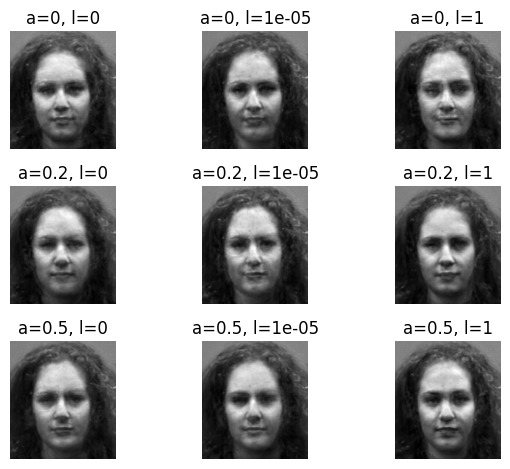

The best parameters are n_comp=75 a=0.2, and l=1e-05


In [55]:
best_a, best_l = prob4()

In [56]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the second and twelfth face in the dataset.
        Plot these basis faces along with the original image using 
        subplots
    '''
    # Get faces data
    faces = get_faces()

    # fit the model using NMF from sklearn
    model = NMF(n_components=75, alpha_W=best_a, l1_ratio=best_l)
    W = model.fit_transform(faces)
    H = model.components_

    for i in [1,11]:  # do both first and twelth
        best = np.argsort(H[:, i])[-10:]

        # plot the original
        plt.subplot(3, 5, 3)
        show(faces[:, i])
        plt.title("Original")
        plt.axis("off")

        for j in range(10):  # plot each basis face
            plt.subplot(3, 5, j + 6)
            show(W[:, best[j]])
            plt.title(f"Basis {j+1}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


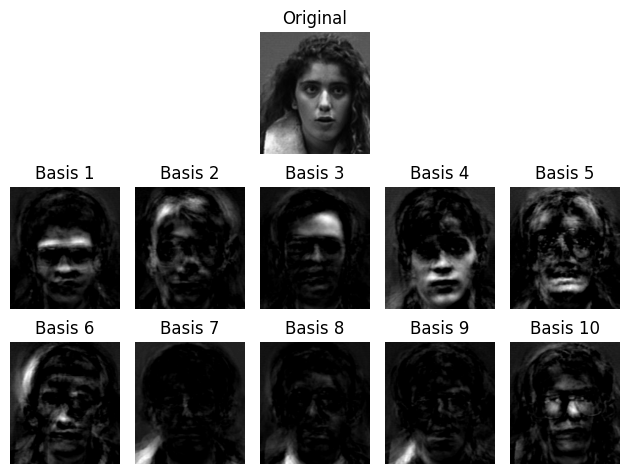

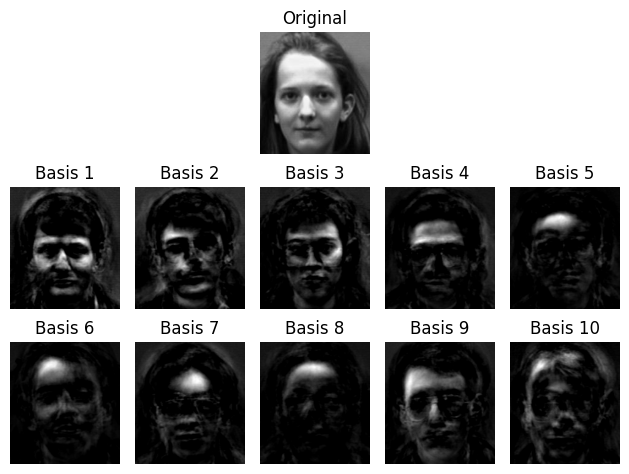

In [57]:
prob5()

In the basis faces there are different features highlighted that are more emphasized. Some of them focus on the hair, forehead, or jaw. Also the higher ranked basis faces seem to have more distinct features.